# Milestone 3
#### Robert Lisy

### Preparation of Data Set

- Source citation for your data set
- Data read from an easily and freely accessible source
- Number of observations and attributes
- Data types
- Distribution of numerical variables
- Distribution of categorical variables
- A comment on each attribute
- Removing cases with missing data
- Removing outliers
- Imputing missing values
- Decoding
- Consolidation
- One-hot encoding
- Normalization

In [1]:
# Data set acquisition and preperation
import pandas as pd
import numpy as np
import requests
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

filename = f"data/adult.csv"

# - Source citation for your data set
# - Data read from an easily and freely accessible source
# This data set is adult income by the US Census Bureau
# Hosted at UC Irvine at the URL here:
# https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

def download_if_not_exists(URL: str, filename: str):
    """
    Helper function to download the file at the URL if it doesn't already exist
    :param URL: A string with the URL location
    :param filename: The file name on disk
    """
    
    if path.exists(f"{filename}"):
        return
    else:
        req = requests.get(URL)
        url_content = req.content
        csv_file = open(f"{filename}", 'wb')
        csv_file.write(url_content)
        csv_file.close()
    return

download_if_not_exists("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                      filename)

# import the CSV as a data set
df = pd.read_csv(filename, header=None)
# - Number of observations and attributes
print(f"(Rows, columns): {df.shape}")

(Rows, columns): (32561, 15)


In [2]:
# - Data types
# First name the columns...        
col_names = {0:'age', 1:'workclass', 2:'fnlwgt', 3:'education', 4:'education_num', 5:'marital_status', 6:'occupation', 
            7:'relationship', 8:'race', 9:'sex', 10:'capital_gain', 11:'capital_loss', 12:'hours_per_week',
            13: 'native_country', 14:'income'}
df.rename(columns = col_names, inplace=True)
# strip junk out of the income column
df['income'] = df['income'].str.strip()
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

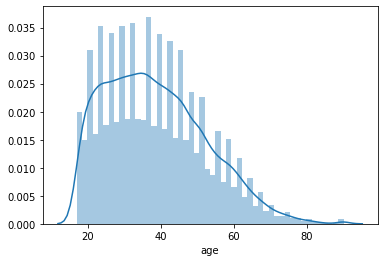

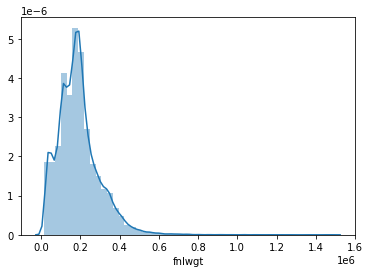

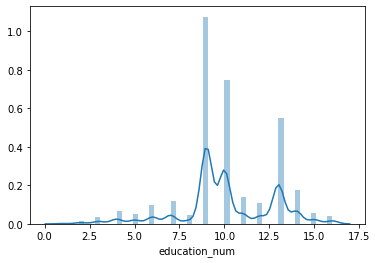

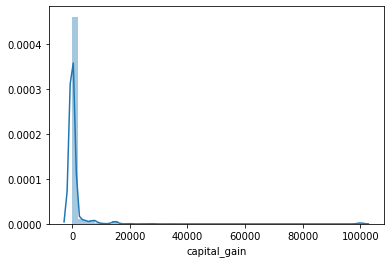

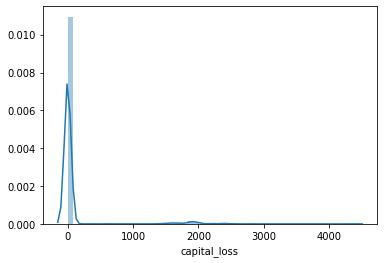

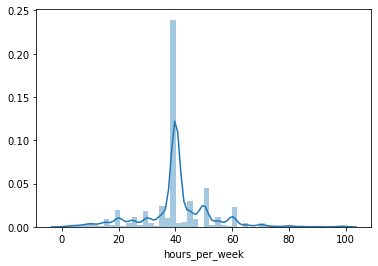

In [3]:
# - Distribution of numerical variables
numeric_cols = df.select_dtypes(include=np.number)

for col in numeric_cols:
    sns.distplot(df[col])
    plt.show()

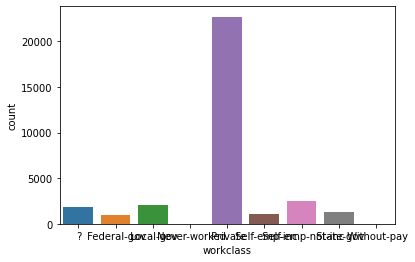

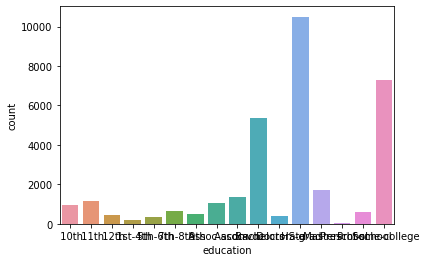

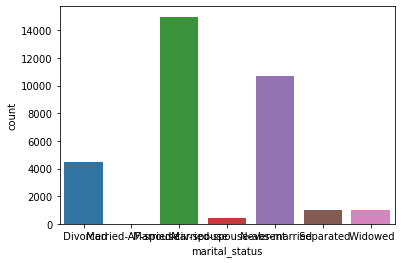

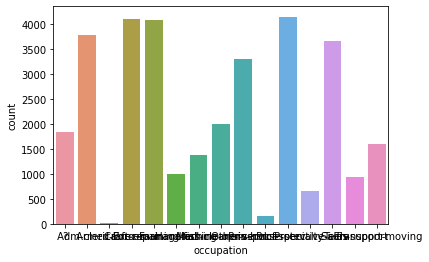

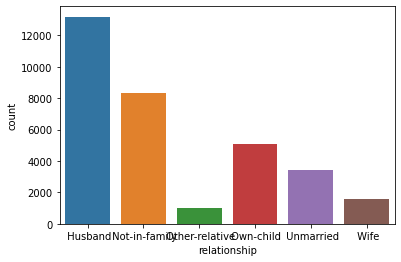

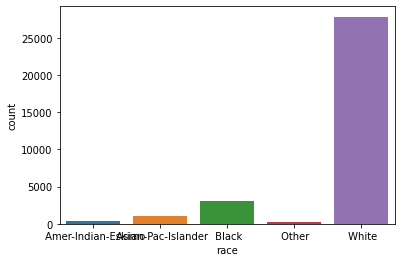

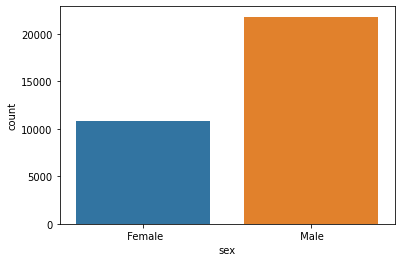

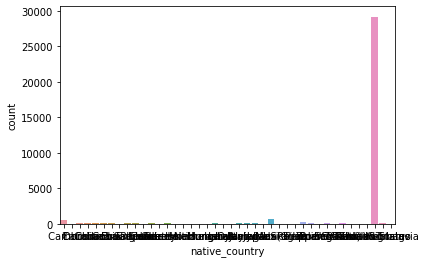

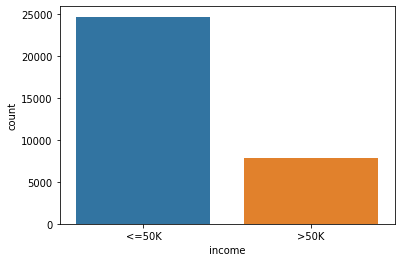

In [4]:
# - Distribution of categorical variables
# Make sure they're categorical
cat_cols = df.select_dtypes(include=[object])

# Convert categorical columns
for c in cat_cols:
    df[c] = df[c].astype('category')

for col in cat_cols:
    sns.countplot(df[col])
    plt.show()

### A comment on each attribute

- age - person's age (integer)
- workclass - type of employment
- fnlwgt - weight of the observations, used to balance the row out to the entire population of the US.
- education - level of education as text
- education_num - years of education, as integer
- marital_status - married, unmarried, divorced, etc.
- occupation - type of job, as text
- relationship - 
- race - black, white, etc
- sex - male / female
- capital_gain - $ amount of captial gains earned
- capital_loss - $ amount of capital losses
- hours_per_week - number of hours worked per week
- native_country - country of birth
- income - binary, does this person make more that $50k USD / year

In [5]:
# - Removing cases with missing data
df = df.dropna(axis=0)

# Also dropping columns which are useless (fnlwgt), and replacing '?' values with "Unknown"
drops = ['fnlwgt']
df = df.drop(drops, axis=1)
df['native_country'] = df['native_country'].str.replace('?', 'United-States')
df['occupation'] = df['occupation'].str.replace('?', 'Unknown')
df['workclass'] = df['workclass'].str.replace('?', 'Unknown')

df.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [6]:
# - Removing outliers
# We saw outliers in:
# - capital_gain

capital_gain_cap = df['capital_gain'].std() * 3
df['capital_gain_capped'] = df['capital_gain'].apply(lambda x: capital_gain_cap if x >= capital_gain_cap else x)

df['capital_gain_capped'].max()

22155.876254521016

In [7]:
#- Impute missing values

# which columns have missing values?
df.isnull().sum()

# Yippie, none.

#- Decoding
# I have no idea what this means... meh.

age                    0
workclass              0
education              0
education_num          0
marital_status         0
occupation             0
relationship           0
race                   0
sex                    0
capital_gain           0
capital_loss           0
hours_per_week         0
native_country         0
income                 0
capital_gain_capped    0
dtype: int64

In [8]:
#- Consolidation
# Education levels seeem like a great candidate for consolidating many categories into fewer, as does workclass, and native country.
bins = [0, 18, 24, 34, 44, 54, 64, np.inf]
names = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['age_group'] = pd.cut(df['age'], bins, labels=names)

# Mapping native countries to greater geographic areas (continents)
m = {"North America":['United-States', 'Canada', 'Outlying-US(Guam-USVI-etc)'],
     "Central/South America": ['Mexico','El-Salvador', 'Dominican-Republic', 'Guatemala', 'Columbia', 'Nicaragua', 'Peru', 'Ecuador', 'Honduras'],
     "Carribean":['Puerto-Rico', 'Cuba', 'Jamacia', 'Hati', 'Trinadad&Tobago'],
     "Europe": ['Germany','England', 'Italy', 'Poland', 'Portugal', 'Greece', 'France', 'Ireland', 'Yugoslavia', 'Scotland', 'Holand-Netherlands'], 
     "Asia": ['Philippines', 'India', 'China', 'Vietnam', 'Japan', 'Taiwan', 'Hong', 'Hong Kong', 'Cambodia', 'Laos', 'Thailand'],
     "Middle East": ['Iran'],
     "Unknown": ['South']
     }
m2 = {v: k for k,vv in m.items() for v in vv}

# make sure there's no junk in the native_country column
df['native_country'] = df['native_country'].str.strip()
# map the values
df['native_country_group'] = df['native_country'].map(m2)

# Mapping workclass into some fewer catgories
# NB - I'm placing people with unknown workclass into "Industry", as that's by far the most common
wc_map = {"Industry": ['Private','Self-emp-not-inc','Self-emp-inc', "Unknown"],
         "Government": ['Local-gov', 'State-gov','Federal-gov'],
         "Unemployed": ['Without-pay', 'Never-worked']}

m2 = {v: k for k,vv in wc_map.items() for v in vv}
df['workclass'] = df['workclass'].str.strip()
df['workclass_group'] = df['workclass'].map(m2)

occ_type_map = {"Blue Collar": ['Craft-repair', 'Unknown', 'Machine-op-inspct', 'Priv-house-serv', 'Transport-moving', 'Other-service', 'Handlers-cleaners'],
                "White Collar": ['Prof-specialty','Exec-managerial', 'Adm-clerical', 'Sales', 'Tech-support'],
                "Agricultural": ['Farming-fishing'],
                "Defense": ['Protective-serv', 'Armed-Forces']}
m2 = {v: k for k,vv in occ_type_map.items() for v in vv}
df['occupation'] = df['occupation'].str.strip()
df['occupation_group'] = df['occupation'].map(m2)


In [9]:
df.dtypes

age                        int64
workclass                 object
education               category
education_num              int64
marital_status          category
occupation                object
relationship            category
race                    category
sex                     category
capital_gain               int64
capital_loss               int64
hours_per_week             int64
native_country            object
income                  category
capital_gain_capped      float64
age_group               category
native_country_group      object
workclass_group           object
occupation_group          object
dtype: object

In [10]:
# Big ole drop
# I'm chosing to drop many of the columns that I've provided groups for, and capital_gains (raw)
drops = ['workclass', 'education', 'occupation', 'capital_gain', 'native_country']
df = df.drop(drops, axis=1)

In [11]:
# - One-hot encoding
# - Normalization

# Let's one-hot encode our nice grouped variables, plus race, marital status, and sex
one_hot_encode_cols = ['race', 'age_group', 'native_country_group', 'workclass_group', 'occupation_group', 'marital_status', 'sex']

def one_hot_encode(df1, 
                   col: str,
                   prefix: str):
    """
    Helper function to:
    - one hot encode a categorical column
    - add a prefix (string)
    - drop the source column from the data frame
    - concatenate the data frame and return it
    
    :param df1: source dataframe
    :param col: column name to one hot encode
    :param prefix: string for the prefix of one hot encoded values
    """
    return pd.concat([df1, pd.get_dummies(df1[col],
                                        prefix=prefix,
                                        dummy_na=True)],
                   axis=1).drop([col], axis=1)

for col in one_hot_encode_cols:
    df = one_hot_encode(df, col, f"{col}_")


In [12]:
df.head()

,age,education_num,relationship,capital_loss,hours_per_week,income,capital_gain_capped,race__ Amer-Indian-Eskimo,race__ Asian-Pac-Islander,race__ Black,...,marital_status__ Married-AF-spouse,marital_status__ Married-civ-spouse,marital_status__ Married-spouse-absent,marital_status__ Never-married,marital_status__ Separated,marital_status__ Widowed,marital_status__nan,sex__ Female,sex__ Male,sex__nan
0,39,13,Not-in-family,0,40,<=50K,2174.0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,50,13,Husband,0,13,<=50K,0.0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,38,9,Not-in-family,0,40,<=50K,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,53,7,Husband,0,40,<=50K,0.0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,28,13,Wife,0,40,<=50K,0.0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


### Unsupervised Learning
- Perform a K-Means with sklearn using some of your attributes.
- Include at least one categorical column and one numeric attribute. Neither may be a proxy for the expert label in supervised learning.
- Normalize the attributes prior to K-Means or justify why you didn't normalize.
- Add the cluster label to the data set to be used in supervised learning

In [13]:
# Kmeans should be run on normalized data.... do that first
which_cols = ['age', 'education_num', 'capital_loss', 'capital_gain_capped', 'hours_per_week']
 which_cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)

df.head()

,age,education_num,relationship,capital_loss,hours_per_week,income,capital_gain_capped,race__ Amer-Indian-Eskimo,race__ Asian-Pac-Islander,race__ Black,...,marital_status__ Widowed,marital_status__nan,sex__ Female,sex__ Male,sex__nan,age_zscore,education_num_zscore,capital_loss_zscore,capital_gain_capped_zscore,hours_per_week_zscore
0,39,13,Not-in-family,0,40,<=50K,2174.0,0,0,0,...,0,0,0,1,0,0.030671,1.134739,-0.21666,0.517447,-0.035429
1,50,13,Husband,0,13,<=50K,0.0,0,0,0,...,0,0,0,1,0,0.837109,1.134739,-0.21666,-0.239160,-2.222153
2,38,9,Not-in-family,0,40,<=50K,0.0,0,0,0,...,0,0,0,1,0,-0.042642,-0.420060,-0.21666,-0.239160,-0.035429
3,53,7,Husband,0,40,<=50K,0.0,0,0,1,...,0,0,0,1,0,1.057047,-1.197459,-0.21666,-0.239160,-0.035429
4,28,13,Wife,0,40,<=50K,0.0,0,0,1,...,0,0,1,0,0,-0.775768,1.134739,-0.21666,-0.239160,-0.035429


In [14]:
# We shouldn't Kmeans on every column!
# Grab Z-scored columns for clustering (our numerical attribute)
zscores = [col for col in df if col.endswith('zscore')]

# add a categorical attribute
sex_cols = list(['sex__ Female', 'sex__ Male'])
cluster_cols = zscores + sex_cols

# NB - I haven't used `income` in the clustering algorithms.
# Therefore the K-means should be completely unaware of this value.

n_clusters = 4 # the number of clusters

X = df[cluster_cols]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
df['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row

# See how our clustering did...
df['cluster'].value_counts()

0    15041
1    14624
2     1484
3     1412
Name: cluster, dtype: int64

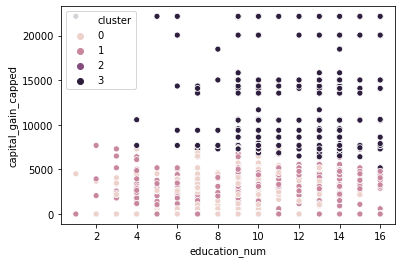

In [15]:
# More clustering visualization
sns.scatterplot(x = 'education_num', 
                y = 'capital_gain_capped', 
                hue = 'cluster', 
                data = df);

### Supervised Learning
- Ask a binary-choice question that describes your classification. Write the question as a comment.
- Split your data set into training and testing sets using the proper function in sklearn.
- Use sklearn to train two classifiers on your training set, like logistic regression and random forest. 
- Apply your (trained) classifiers to the test set.
- Create and present a confusion matrix for each classifier. Specify and justify your choice of probability threshold.
- For each classifier, create and present 2 accuracy metrics based on the confusion matrix of the classifier.
- For each classifier, calculate the ROC curve and it's AUC using sklearn. Present the ROC curve. Present the AUC in the ROC's plot.

In [29]:
# Accuracy measures
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import accuracy_score
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
# And test/train splitting
from sklearn.model_selection import train_test_split

In [23]:
# Binary choice question:
# is this person's income expected to be above $50k USD, yes or no?
# - Split your data set into training and testing sets using the proper function in sklearn.

# Here's the star of the show... let's make sure this column has no junky text in it.
df['income_bool'] = df['income'].map({'<=50K':0, '>50K':1})
df = df.drop('income', axis=1)
df['income_bool'].value_counts()

0    24720
1     7841
Name: income_bool, dtype: int64

In [27]:
# Time to drop out the columns which are NOT numeric
drops=['relationship']
df = df.drop(columns=drops, axis=1)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = "income_bool"), df["income_bool"], 
                                                    test_size = 0.15, random_state = 32768)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
print(f"Training data has {X_train.shape[0]} rows.")
print(f"Test data has {X_test.shape[0]} rows.")
df.head()

Training data has 27676 rows.
Test data has 4885 rows.


,age,education_num,capital_loss,hours_per_week,capital_gain_capped,race__ Amer-Indian-Eskimo,race__ Asian-Pac-Islander,race__ Black,race__ Other,race__ White,...,sex__ Female,sex__ Male,sex__nan,age_zscore,education_num_zscore,capital_loss_zscore,capital_gain_capped_zscore,hours_per_week_zscore,cluster,income_bool
0,39,13,0,40,2174.0,0,0,0,0,1,...,0,1,0,0.030671,1.134739,-0.21666,0.517447,-0.035429,1,0
1,50,13,0,13,0.0,0,0,0,0,1,...,0,1,0,0.837109,1.134739,-0.21666,-0.239160,-2.222153,1,0
2,38,9,0,40,0.0,0,0,0,0,1,...,0,1,0,-0.042642,-0.420060,-0.21666,-0.239160,-0.035429,0,0
3,53,7,0,40,0.0,0,0,1,0,0,...,0,1,0,1.057047,-1.197459,-0.21666,-0.239160,-0.035429,1,0
4,28,13,0,40,0.0,0,0,1,0,0,...,1,0,0,-0.775768,1.134739,-0.21666,-0.239160,-0.035429,0,0


In [33]:
# - Use sklearn to train two classifiers on your training set, like logistic regression and random forest. 
# Decision Tree
dtree = DecisionTreeClassifier(max_depth = 15)
dtree.fit(X_train, y_train)
dtree_y_hat_train = dtree.predict(X_train)
dtree_y_hat_test = dtree.predict(X_test)

# Confusion Matrix
dtree_confusion_matrix = confusion_matrix(y_test, dtree_y_hat_test)
dtree_confusion_df = pd.DataFrame(logit_confusion_matrix)
print('Logistic Regression Confustion Matrix')
print(dtree_confusion_df)

dtree_acc_train = accuracy_score(y_train, dtree_y_hat_train) * 100
dtree_acc_test = accuracy_score(y_test, dtree_y_hat_test) * 100

print(f"Accuracy on the training data: {dtree_acc_train:.0f}%.")
print(f"Accuracy on the test data: {dtree_acc_test:.0f}%.")

Logistic Regression Confustion Matrix
      0    1
0  3404  225
1   516  740
Accuracy on the training data: 90%.
Accuracy on the test data: 85%.


In [35]:
# Logistic regression baby!
logit = LogisticRegression(max_iter = 5000)
logit.fit(X_train, y_train)
logit_y_hat_train = logit.predict(X_train)
logit_y_hat_test = logit.predict(X_test)

# Print Logistic confusion matrix.
print('Confusion matrix: ')
logit_confusion_matrix = confusion_matrix(y_test, logit_y_hat_test)
logit_confusion_df = pd.DataFrame(logit_confusion_matrix)
print(logit_confusion_df)

logit_acc_train = accuracy_score(y_train, logit_y_hat_train) * 100
logit_acc_test = accuracy_score(y_test, logit_y_hat_test) * 100
print(f"Accuracy on the training data: {logit_acc_train:.0f}%.")
print(f"Accuracy on the test data: {logit_acc_test:.0f}%.")

#- For each classifier, calculate the ROC curve and it's AUC using sklearn. Present the ROC curve. Present the AUC in the ROC's plot.

Confusion matrix: 
      0    1
0  3404  225
1   516  740
Accuracy on the training data: 85%.
Accuracy on the test data: 85%.


In [36]:
#Create a Gaussian Classifier
nb_model = GaussianNB()

# Train the model using the training sets
nb_model.fit(X_train, y_train)

#Predict Output
nb_y_hat_train = nb_model.predict(X_train)
nb_y_hat_test = nb_model.predict(X_test)

# Print Naive Bayes confusion matrix.
print('Naive Bayes Confusion matrix: ')
nb_confusion_matrix = confusion_matrix(y_test, nb_y_hat_test)
nb_confusion_df = pd.DataFrame(nb_confusion_matrix)
print(nb_confusion_df)

nb_acc_train = accuracy_score(y_train, nb_y_hat_train) * 100
nb_acc_test = accuracy_score(y_test, nb_y_hat_test) * 100
print(f"Accuracy on the training data: {nb_acc_train:.0f}%.")
print(f"Accuracy on the test data: {nb_acc_test:.0f}%.")

Naive Bayes Confusion matrix: 
      0    1
0  2965  664
1   263  993
Accuracy on the training data: 80%.
Accuracy on the test data: 81%.


In [38]:
cm_list = [nb_y_hat_test, logit_y_hat_test, dtree_y_hat_test]
cm_names = ['Naive Bayes', 'Logistic', 'Decision Tree']

for m in cm_list:
    print('-----------------------------')
    print('Precision: ')
    print(f"{metrics.precision_score(y_test, m):0.2f}")
    print('Recall: ')
    print(f"{metrics.recall_score(y_test, m):0.2f}")
    print('F1 score: ')
    print(f"{metrics.f1_score(y_test, m):0.2f}")
    print('Pearson\'s Phi: ')
    print(f"{metrics.matthews_corrcoef(y_test, m):0.2f}")


-----------------------------
Precision: 
0.60
Recall: 
0.79
F1 score: 
0.68
Pearson's Phi: 
0.56
-----------------------------
Precision: 
0.77
Recall: 
0.59
F1 score: 
0.67
Pearson's Phi: 
0.58
-----------------------------
Precision: 
0.73
Recall: 
0.64
F1 score: 
0.68
Pearson's Phi: 
0.58


In [39]:
# Let's do some charting of the model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(models, model_names):
    plt.figure(0, figsize = [8, 7]).clf()
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for ii, model in enumerate(models):
        y_prob_test = model.predict_proba(X_test)[:, 1]
        fpr, tpr, threshold = roc_curve(y_test, y_prob_test)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label = "{} AUC = {:0.2f}".format(model_names[ii], roc_auc))

    plt.legend(loc = 'lower right');

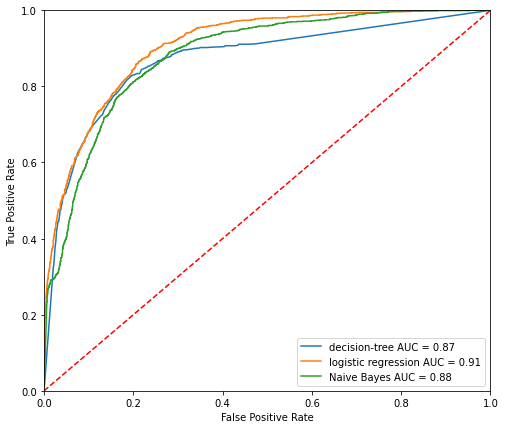

In [40]:
plot_roc([dtree, logit, nb_model], ['decision-tree', 'logistic regression', 'Naive Bayes'])